# Z型フーリエ記述子

Z型フーリエ記述子の理論は連続閉曲線についてのものであるが、ここでは輪郭上に等間隔にN+1個の標本点 $P_i$   i=0,1,2, ..., N を取り（ただし、$P_0=P_N$）、理論中の接線偏角を、直線$P_i P_{i+1}$がX軸となす角＝偏角に置き換えて考えることにする。

ベクトル$\overrightarrow{ P_{i}P_{i+1} }$　と　X軸のなす角を$\theta_i$とする。

$$\Phi_i = (\theta_i-\theta_0)- \frac{2\pi (i\ mod\ N)}{N}$$

を正規化偏角関数とよぶ。$\Phi_i$は周期Nの周期関数となるので、

$$ \Phi_i = \sum^\infty_{k= - \infty} c_k exp(j \frac{2\pi k i}{N}) $$

と、フーリエ級数展開することができる。

いま、標本点の数Nがシャノンの標本化定理により原信号を復元可能な十分な数であるする。これは最大周波数がN/2までであることを意味するので、  

$$\Phi_i = \sum^\frac{N}{2}_{k= - \frac{N}{2} + 1} c_k exp(j \frac{2\pi k i}{N}) $$

と表せるはずである。

ここで、

 $$c_k = \frac{1}{N} \sum^N_{i=1} \Phi_i exp(-j \frac{2\pi ki}{N}) $$

であり、この係数をZ型フーリエ記述子とよぶ。

$$\Phi_i $$ がもとまれば、次式により、標本点の座標 $(x_i,y_i)$えることができる。

$$\theta_i =  \Phi_i +\frac{2\pi (i\ mod\ N)}{N} + \theta_0$$

$$x_i = x_0 + \delta \sum_{i=0}^{i} sin \theta_i$$

$$y_i = y_0 + \delta \sum_{i=0}^{i} cos \theta_i$$

ただし、$\delta$ は標本点間の距離である。

## numpy の高速フーリエ変換

計算時間を短縮するために、高速フーリエ変換FFTを用いることにする。ここでは詳細は述べないが、FFTはデータ数Nを２のべき乗に限定することで計算量を抑えたアルゴリズムである。

以下の実験ではN＝１２８とした。この場合、フーリエ記述子のインデックス０はバイアス（直流成分）、１から６３まではが正の周波数で数字の順に周波数が上がっていき、６５から１２７までは負の周波数で、数字が増えるにしたがって周波数が下がっていく。

折り返しの６４は正と負両方の最大周波数となる。つまり、１周で６４周期、２ピクセル１周期の波が最大周波数の波形成分となる。（しごく真っ当である）

In [1]:
import numpy as np
import matplotlib
# matplotlib.use('Agg') # 表示しないモード。バッチ処理する場合、画像表示が多くなりすぎて　notebooke の制限で途中で止まってしまう。
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import math
import pandas as pd

from sympy import *
from sympy.abc import a,b,c
# init_session()
px,py =var('px:4'),var('py:4')
t = symbols('t')
from sympy import var
from rdlib2 import *

import datetime
import time

import os

# 輪郭データからのひげ除去
def shaver(cnt):  # 輪郭点列のうち、ヒゲ要素を取り除く
    # まず輪郭列のスタート部分がヒゲ要素を取り除く
    while True:
        if len(cnt) > 2 and list(cnt[1][0])==list(cnt[-1][0]): # 最初の点がヒゲの先端
            cnt = cnt[1:-1]
        else:
            break
    # 途中のヒゲ要素を取り除く
    while True:
            l = len(cnt)
            for  i in range(1,len(cnt)-1):
                    if list(cnt[i-1][0]) == list(cnt[i+1][0]):
                            cnt = np.r_[cnt[:i],cnt[i+2:]]
            if l == len(cnt):
                break
    return cnt

# 輪郭に沿った長さ

        
# (x1,y1)から（x2,y2) に向かう直線のX軸に対する角度(0-359)
def getDegree(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        if dx == 0 :
            if dy == 0: # 例外
                deg = 0
            elif dy > 0:
                deg = 90
            else:
                deg = 270
        elif dx >0 and dy >= 0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        elif dx > 0 and dy < 0: 
            deg = 360+180*np.arctan(dy/dx)/np.pi
        else:
            deg =180*(1+ np.arctan(dy/dx)/np.pi)
            # deg = 270.0(1+np.arctan(dy/dx)/np.pi)
        return deg

In [2]:
kohaku='シルエット/17Cylindric/17kohaku1o09_l.jpg'
yakumi ='シルエット/17Spheric/17yakumi2o06_l.jpg'
daruma='シルエット/17Apically/17daruma6o06_l.jpg'
aomida='シルエット/17Horn/17aomida1o02_l.jpg'
nezumi='シルエット/17Inv_tri/17nezumi1o06_l.jpg'

kohakuimg = getstandardShape(cv2.imread(kohaku,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
akumiimg = getstandardShape(cv2.imread(yakumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
aomidaimg = getstandardShape(cv2.imread(aomida,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
nezumiimg = getstandardShape(cv2.imread(nezumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  

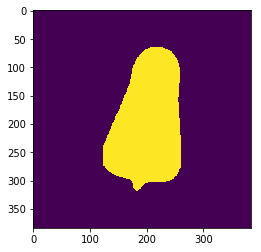

In [3]:
img = nezumiimg
plt.imshow(img)

(202.0, 198.0, (123, 65, 138, 253, 25059))

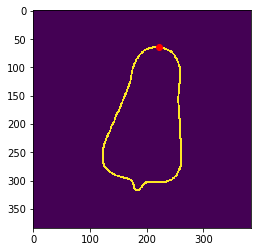

In [4]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[-10][0][0]],[cnt00[-10][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

## まず、経路長を横軸、X,Yを縦軸に取ったグラフ

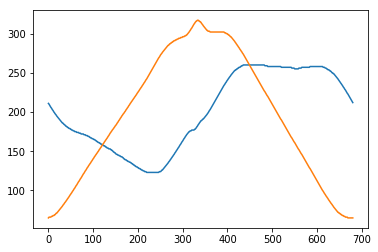

In [5]:
# 輪郭に沿った長さの列 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

# サンプリング
点の数が多すぎるので、128点だけサンプリングしてみる

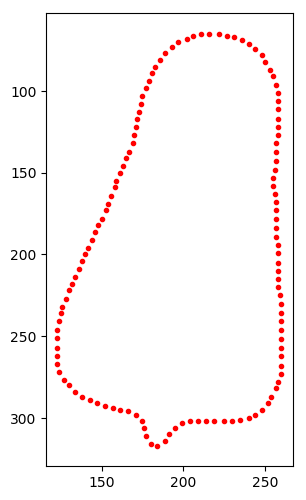

In [6]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
needLengs = np.linspace(0,allLength,SPANS+1)
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
    for j in range(index,len(cnt00)):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
# 表示して確認
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")

サンプル点だけでX,Yをプロットして十分かどうか確認

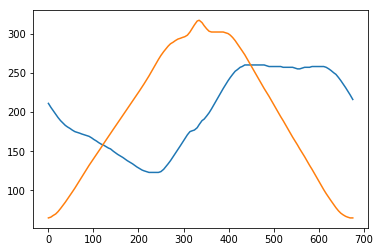

In [7]:
# 128点でプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

# フーリエ変換

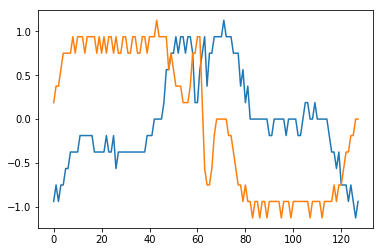

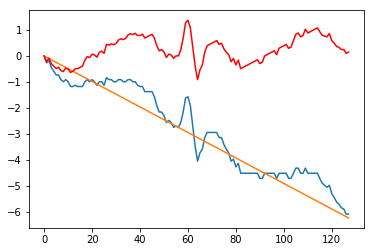

In [8]:
# Z型は複素表現を使わないが、角度計算のプログラムが楽なので、複素表現しておく。
z = [x + y*1j  for [x,y] in samples]
# 偏角の複素表現
w = [(z1 - z0)/allLength*SPANS for (z1,z0) in zip(z[1:],z[:-1])]
w.append((z[0] - z[-1])/allLength*SPANS)
w = np.array(w)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.real)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.imag)
plt.show()
# 偏角(degree)のプロット
import cmath
# 偏角関数
ph0 = [cmath.phase(w[0])]
for c in w[1:]:
    ph0.append((cmath.phase(c)) if abs(cmath.phase(c) - ph0[-1]) < np.pi  else (cmath.phase(c) - 2*np.pi))
phi = [ph0[i] - ph0[0] + 2*np.pi*i/SPANS for i in range(len(ph0))] # 正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[ph0[i]-ph0[0] for i in range(len(ph0))])
plt.plot(np.linspace(0,SPANS-1,SPANS),[-2*np.pi*i/SPANS for i in range(SPANS)])
plt.plot(np.linspace(0,SPANS-1,SPANS),phi,color='red') # 正規化偏角関数

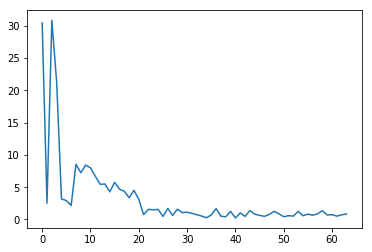

In [9]:
# フーリエ変換
W= np.fft.fft(phi)

# スペクトラム表示
W_abs = np.abs(W)
W_abs_amp = W_abs / SPANS *2 # 交流成分はデータ数で割って2倍
W_abs_amp[0] = W_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

fq = np.linspace(0,  int(SPANS/2)-1,  int(SPANS/2))
plt.plot(fq, W_abs[: int(SPANS/2)])

# フーリエ逆変換

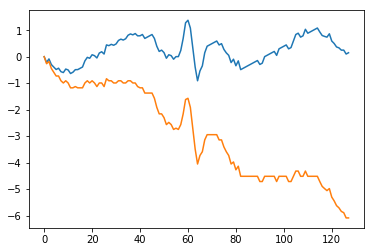

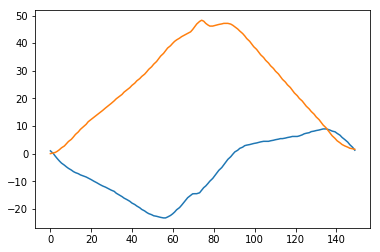

In [10]:
# フーリエ逆変換
phi_ifft= np.fft.ifft(W)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)         

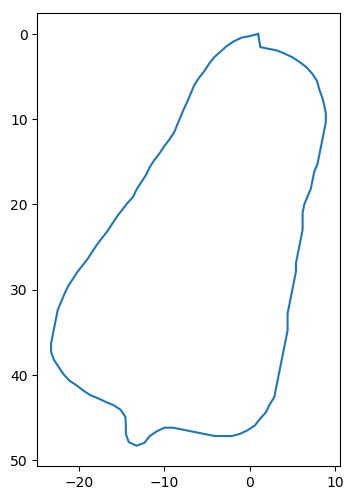

In [11]:
# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])

#  ローパスフィルタ
高周波成分をカット



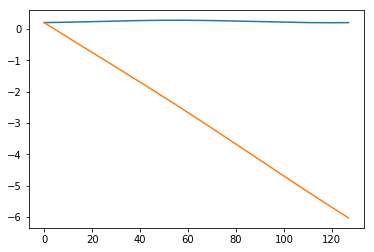

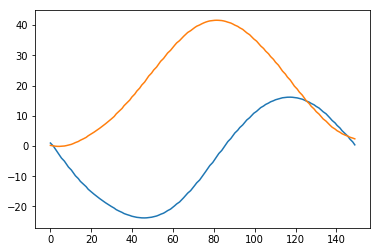

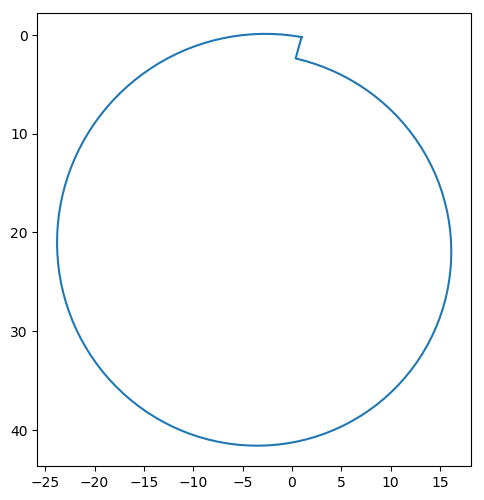

In [12]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[2:-1]=0+0j # 0,1 のみ　
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])       

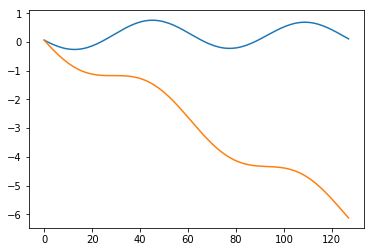

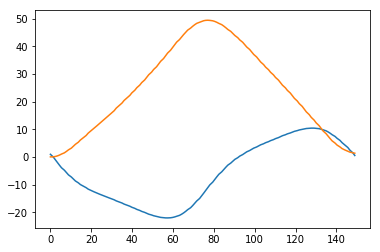

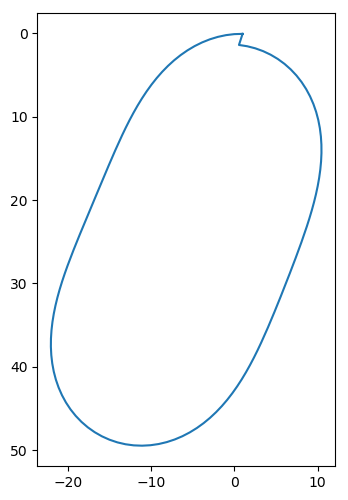

In [13]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[3:-2]=0+0j # 0,1,2のみ　
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])    

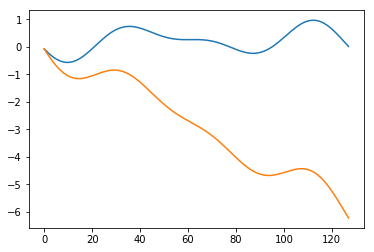

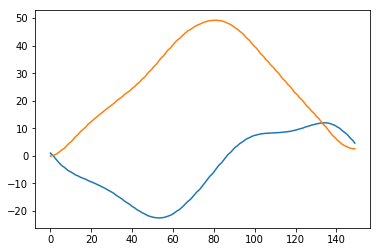

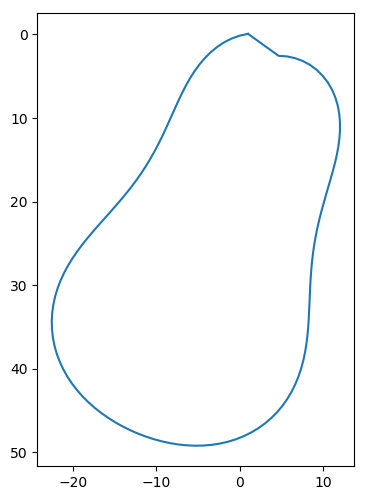

In [14]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[ 4:-3]=0+0j # 0,1 ,2、３ 　
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])    

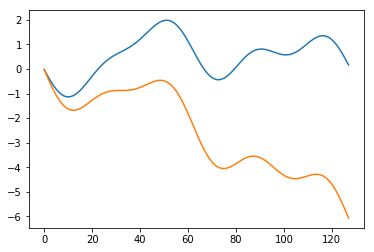

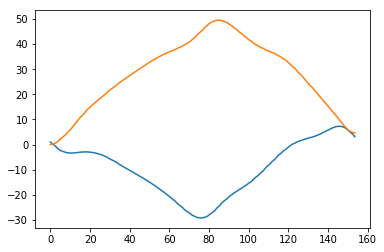

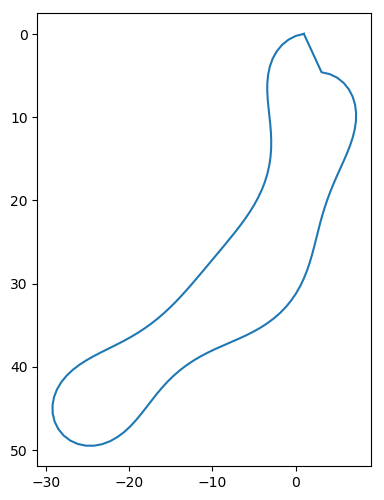

In [35]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[5:-4]=0+0j # 0,1 ,2,3 ,4
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])    

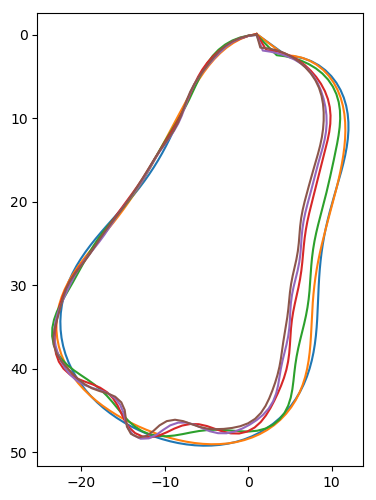

In [16]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    phi_ifft = np.fft.ifft(W_cut)
    phi_ifft_real  = phi_ifft.real
    angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
    y =[np.sin(angle[0])]
    x =[np.cos(angle[0])]
    for i in range(1,len(phi_ifft)):
        sx = x[-1] - np.cos(angle[i])
        sy = y[-1] - np.sin(angle[i])
        x.append(sx)
        y.append(sy)
    # 復元
    plt.gca().invert_yaxis() 
    plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

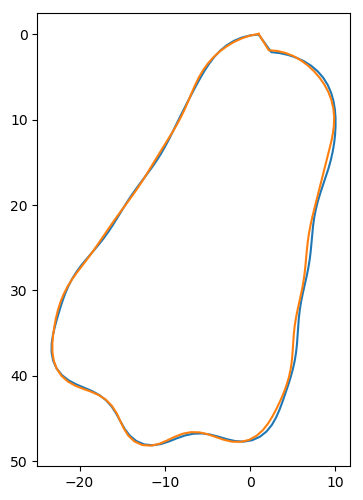

In [17]:
# 12-14項 近似
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(12,14):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    phi_ifft = np.fft.ifft(W_cut)
    phi_ifft_real  = phi_ifft.real
    angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
    y =[np.sin(angle[0])]
    x =[np.cos(angle[0])]
    for i in range(1,len(phi_ifft)):
        sx = x[-1] - np.cos(angle[i])
        sy = y[-1] - np.sin(angle[i])
        x.append(sx)
        y.append(sy)
    # 復元
    plt.gca().invert_yaxis() 
    plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

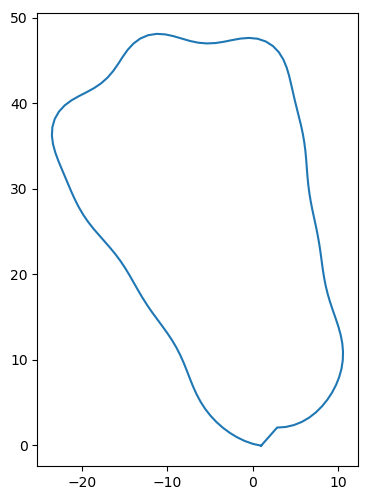

In [18]:
# 11-12項 近似
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(11,12):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    phi_ifft = np.fft.ifft(W_cut)
    phi_ifft_real  = phi_ifft.real
    angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
    y =[np.sin(angle[0])]
    x =[np.cos(angle[0])]
    for i in range(1,len(phi_ifft)):
        sx = x[-1] - np.cos(angle[i])
        sy = y[-1] - np.sin(angle[i])
        x.append(sx)
        y.append(sy)
    # 復元
    plt.gca().invert_yaxis() 
    plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

## なぜか180度回転する

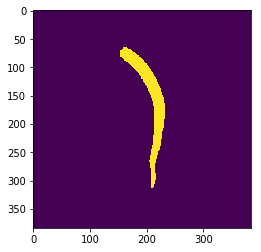

In [20]:
img = aomidaimg
plt.imshow(img)

(205.0, 162.0, (153, 66, 79, 249, 4474))

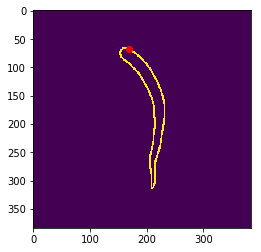

In [21]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[-10][0][0]],[cnt00[-10][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

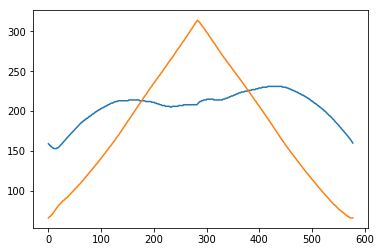

In [22]:
# 輪郭に沿った長さの列 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

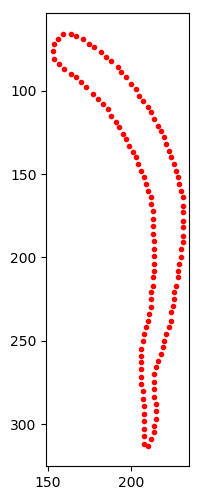

In [23]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
needLengs = np.linspace(0,allLength,SPANS+1)
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
    for j in range(index,len(cnt00)):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
# 表示して確認
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")

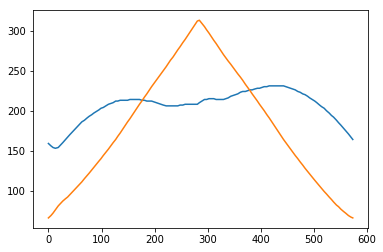

In [24]:
# 128点でプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

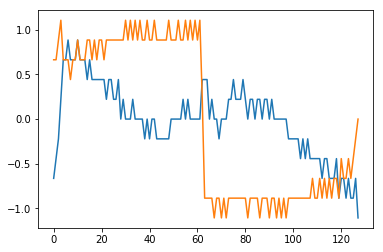

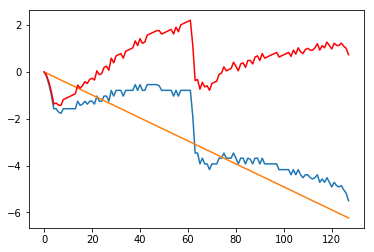

In [25]:
# Z型は複素表現を使わないが、角度計算のプログラムが楽なので、複素表現しておく。
z = [x + y*1j  for [x,y] in samples]
# 偏角の複素表現
w = [(z1 - z0)/allLength*SPANS for (z1,z0) in zip(z[1:],z[:-1])]
w.append((z[0] - z[-1])/allLength*SPANS)
w = np.array(w)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.real)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.imag)
plt.show()
# 偏角(degree)のプロット
import cmath
# 偏角関数
ph0 = [cmath.phase(w[0])]
for c in w[1:]:
    ph0.append((cmath.phase(c)) if abs(cmath.phase(c) - ph0[-1]) < np.pi  else (cmath.phase(c) - 2*np.pi))
phi = [ph0[i] - ph0[0] + 2*np.pi*i/SPANS for i in range(len(ph0))] # 正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[ph0[i]-ph0[0] for i in range(len(ph0))])
plt.plot(np.linspace(0,SPANS-1,SPANS),[-2*np.pi*i/SPANS for i in range(SPANS)])
plt.plot(np.linspace(0,SPANS-1,SPANS),phi,color='red') # 正規化偏角関数

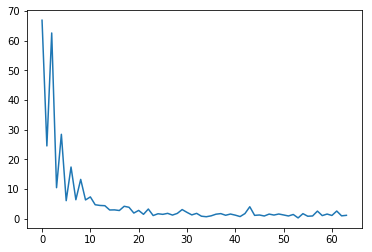

In [26]:
# フーリエ変換
W= np.fft.fft(phi)

# スペクトラム表示
W_abs = np.abs(W)
W_abs_amp = W_abs / SPANS *2 # 交流成分はデータ数で割って2倍
W_abs_amp[0] = W_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

fq = np.linspace(0,  int(SPANS/2)-1,  int(SPANS/2))
plt.plot(fq, W_abs[: int(SPANS/2)])

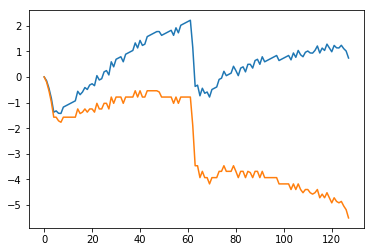

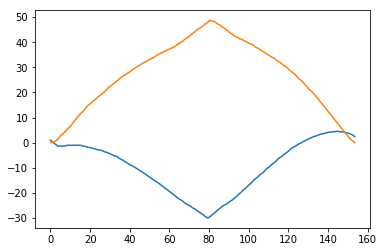

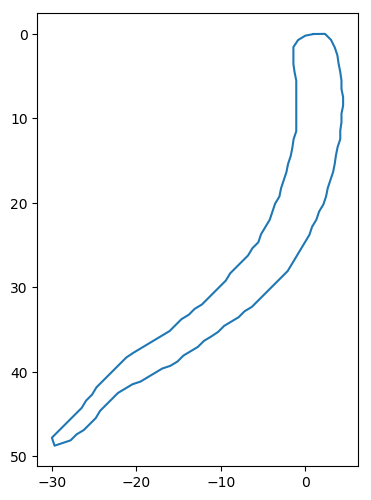

In [27]:
# フーリエ逆変換
phi_ifft= np.fft.ifft(W)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)     

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])

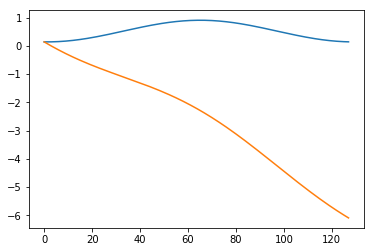

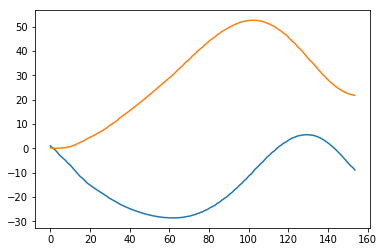

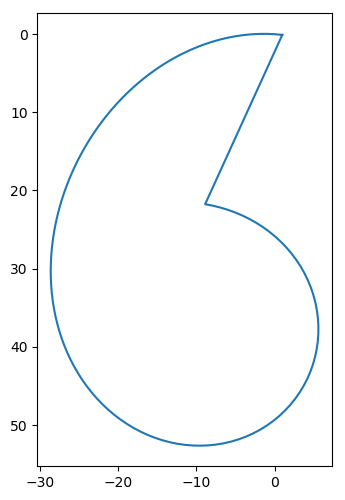

In [28]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[2:-1]=0+0j # 0,1 のみ　
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])       

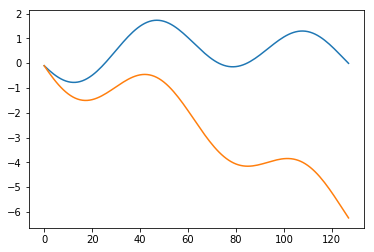

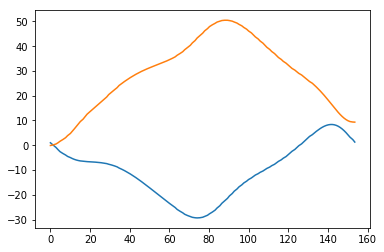

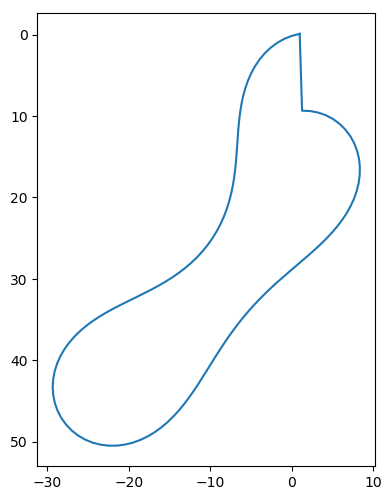

In [29]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[3:-2]=0+0j # 0,1,2のみ　
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

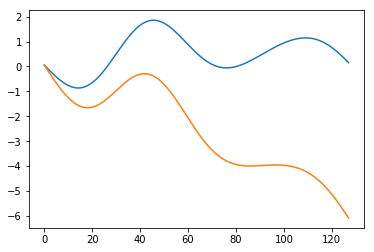

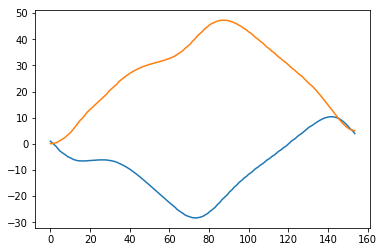

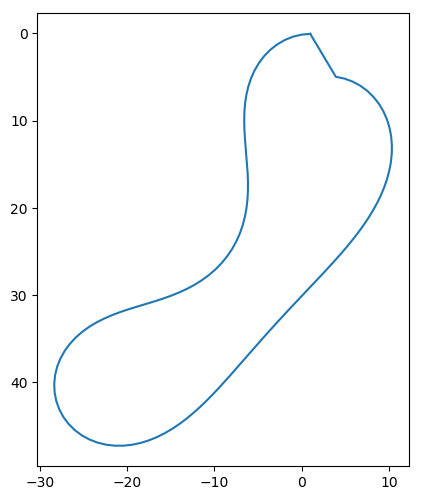

In [30]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[4:-3]=0+0j # 0,1 のみ　
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

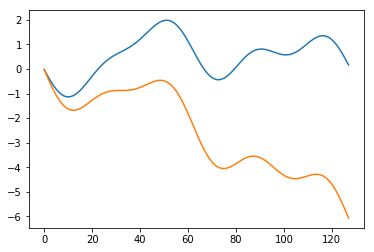

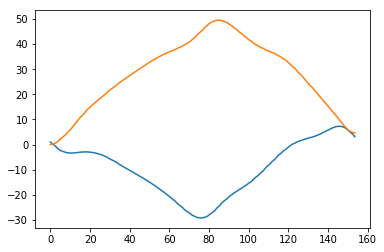

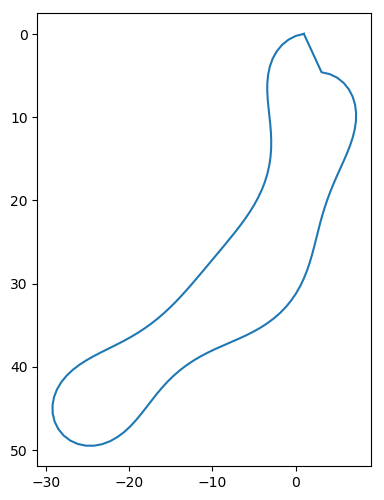

In [31]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[5:-4]=0+0j # 0,1 のみ　
phi_ifft = np.fft.ifft(W_cut)
phi_ifft_real  = phi_ifft.real
angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
plt.plot(np.linspace(0,SPANS-1,SPANS),phi_ifft_real) #  正規化偏角関数
plt.plot(np.linspace(0,SPANS-1,SPANS),[a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)])
plt.show() 

y =[np.sin(angle[0])]
x =[np.cos(angle[0])]
for i in range(1,len(phi_ifft)):
    sx = x[-1] - np.cos(angle[i])
    sy = y[-1] - np.sin(angle[i])
    x.append(sx)
    y.append(sy)
x,y = np.array(x),np.array(y) 
plt.plot([lengs[i] for i in range(SPANS)],x)
plt.plot([lengs[i] for i in range(SPANS)],y)      

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

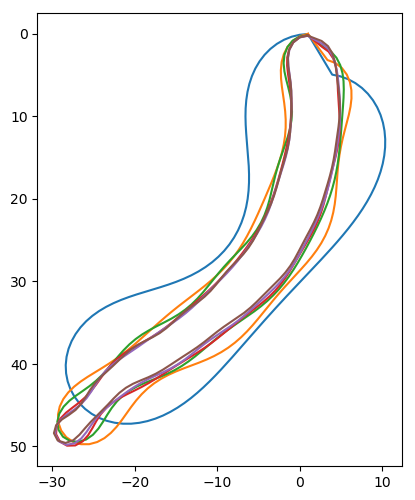

In [32]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    phi_ifft = np.fft.ifft(W_cut)
    phi_ifft_real  = phi_ifft.real
    angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
    y =[np.sin(angle[0])]
    x =[np.cos(angle[0])]
    for i in range(1,len(phi_ifft)):
        sx = x[-1] - np.cos(angle[i])
        sy = y[-1] - np.sin(angle[i])
        x.append(sx)
        y.append(sy)
    # 復元
    plt.gca().invert_yaxis() 
    plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

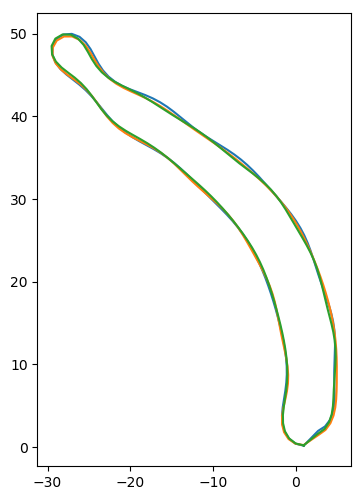

In [33]:
# 11-14項 近似
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(11,14):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    phi_ifft = np.fft.ifft(W_cut)
    phi_ifft_real  = phi_ifft.real
    angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
    y =[np.sin(angle[0])]
    x =[np.cos(angle[0])]
    for i in range(1,len(phi_ifft)):
        sx = x[-1] - np.cos(angle[i])
        sy = y[-1] - np.sin(angle[i])
        x.append(sx)
        y.append(sy)
    # 復元
    plt.gca().invert_yaxis() 
    plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

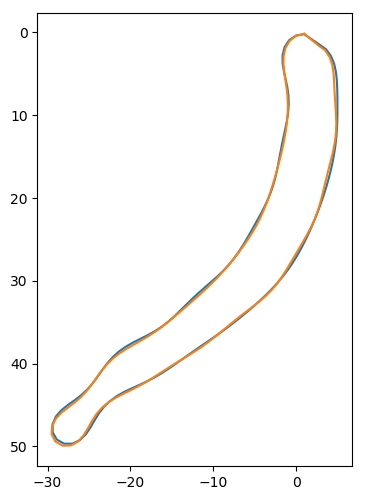

In [34]:
# 12-14項 近似
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(12,14):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    phi_ifft = np.fft.ifft(W_cut)
    phi_ifft_real  = phi_ifft.real
    angle = [a-2*np.pi*i/SPANS for i,a in enumerate(phi_ifft_real)]
    y =[np.sin(angle[0])]
    x =[np.cos(angle[0])]
    for i in range(1,len(phi_ifft)):
        sx = x[-1] - np.cos(angle[i])
        sy = y[-1] - np.sin(angle[i])
        x.append(sx)
        y.append(sy)
    # 復元
    plt.gca().invert_yaxis() 
    plt.plot(np.r_[x,x[0]],np.r_[y,y[0]])  

参考

http://www.design.kyushu-u.ac.jp/lib/doctor/1999/k032/k032-03.pdf

http://lbm.ab.a.u-tokyo.ac.jp/~iwata/software/shape_r/shape_r_ppt.pdf

http://www.ic.is.tohoku.ac.jp/~swk/lecture/yaruodsp/dft.html#SECTION00850000000000000000